# Kickstarter Projects 
### CSC 478 Final Project
#### Synopsis:
* The purpose of this project is to predict whether a kickstarter campaign will fail, succeed, or cancel based on the available information available [here](https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv).
* We will use an array of machine learning algorithms, including KNN, Linear Regression, Logistic Regression, and / or SVM to find the most accurate model.

#### Contributors:
* [Rebecca Tung (1448196)](https://github.com/rtungus)
* [Sidney Fox (1524992)](https://github.com/stfox13)

#### Data Dictionary:


##### Content
You'll find most useful data for project analysis. Columns are self explanatory except:

1. usd_pledged: conversion in US dollars of the pledged column (conversion done by kickstarter).

2. usd pledge real: conversion in US dollars of the pledged column (conversion from Fixer.io API).

3. usd goal real: conversion in US dollars of the goal column (conversion from Fixer.io API).


|Sequence Number|Column Name|Data Type|
|:---|:---|:---|
|1|ID|Numeric|
|2|name|String|
|3|category|String|
|4|main_category|String|
|5|currency|String|
|6|deadline|DateTime|
|7|goal|Numeric|
|8|launched|DateTime|
|9|pledged|Numeric|
|10|state|String|
|11|backers|Numeric|
|12|country|String|
|13|usd pledged|Numeric|
|14|usd_pledged_real|Numeric|
|15|usd_goal_real|Numeric|

## Libraries used through the project:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#import plotly.plotly as py
import numpy as np
import pandas as pd
import seaborn as sns
import os
import math
import requests
import datetime as dt
import matplotlib as mpl
import io
from pandas import Series, DataFrame
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer, LabelEncoder
from sklearn import svm
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import itertools
from sklearn.feature_selection import RFE
from collections import defaultdict
import pylab

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#Set graph size
mpl.rcParams['figure.figsize'] = (10,10)

In [4]:
np.set_printoptions(suppress=True)

In [5]:
def roundup(x, y):
    #return int(math.ceil(x / float(y))) * y
    return int(math.ceil(x / y) * y)

## Load raw data as Pandas DataFrame:

In [6]:
url = 'https://raw.githubusercontent.com/stfox13/CSC478FinalProject/master/Data/ks-projects-201801.csv'
kickproj_org= pd.read_csv(url)
print "Total rows in dataset:",len(kickproj_org)

Total rows in dataset: 378661


In [7]:
len(kickproj_org.columns)

15

## Define Useful Functions

In [8]:
#Define a fuction to print and plot confusin matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
#   print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [9]:
#Define a fuction to calculate and print TP, TN, FP, and FN for each category
def show_statistics(test_y, y_pred, matrix):
    TP = np.diag(matrix)
    FP = np.sum(matrix, axis=0) - TP
    FN = np.sum(matrix, axis=1) - TP
    TN = []
    for i in range(len(matrix)):
        temp = np.delete(matrix, i, 0)    # delete ith row
        temp = np.delete(temp, i, 1)  # delete ith column
        TN.append(sum(sum(temp)))    
    temp_dic = {'TP': TP, 'FP' : FP, 
                'TN' : TN, 'FN' : FN}
    scoreMatrix = DataFrame.from_dict(temp_dic)
    #print "TP, TN, FP, FN for each cateory: "
    return scoreMatrix

In [10]:
# Define a fuction to print F1 Score for each class and global (micro)
def formatResult(preResult, columnNames):  
    resultDF = DataFrame(preResult.values(), columns=columnNames, index=preResult.keys())
    resultDF.loc['sum'] = np.sum(preResult.values(), axis=0)
    resultDF['Sum of Class F1'] = np.append(np.sum(preResult.values(), axis=1), np.NaN)
    return resultDF

In [11]:
#######KNN############
#Define a function to run KNeighborsClassifier with different n_neighbors and store f1 score
def runKNN(trainX, trainY, testX, testY, number, f1_only = False, trainSetName = '', dic_result_knn = {}):
    i = 3
    cls = KNeighborsClassifier(n_neighbors=i)
    while i <= number:
        #print i
        cls = KNeighborsClassifier(n_neighbors=i)
        cls.fit(trainX, trainY)
        predY = cls.predict(testX)
        result = f1_score(testY, predY, average=None).round(2)
        result = np.append(result, f1_score(testY, predY, average='micro').round(2))
        
        #print results
        dic_result_knn['N=' + str(i) +'-' + trainSetName] = result
        #print "n_neighbors = " + str(i) + " : " + result
        i = i + 2
    return dic_result_knn

In [12]:
#######LogisticRegression############
# Define a function to run LogisticRegression with different class_weight settings and store f1 score
def runLogistic(trainX, trainY, testX, testY, f1_only = False, trainSetName = '', dic_result_log = {}):
    cls = LogisticRegression() 
    cls.fit(trainX, trainY)
    predY = cls.predict(testX)
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    dic_result_log['CWeight = None - ' + trainSetName] = result 
    
    cls = LogisticRegression(class_weight='balanced')
    cls.fit(trainX, trainY)
    predY = cls.predict(testX)
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    dic_result_log['CWeight = balanced - ' + trainSetName] = result   
    return dic_result_log

In [13]:
#######SVM############
# Define a function to run SVM with different kernel settings and store f1 score
def runSVM(trainX, trainY, testX, testY, f1_only = False, trainSetName = '', dic_result_log = {}):
    
    C = 1.0 # SVM regularization parameter
    svc = svm.SVC(kernel='linear', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    predY = svc.predict(X_plot)        
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    print results
    dic_result_log['SVCKernel = linear - ' + trainSetName] = result 
    
    svc = svm.SVC(kernel='rbf', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    predY = svc.predict(X_plot)        
    result = f1_score(testY, predY, average=None).round(2)
    result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    print results
    dic_result_log['SVCKernel = rbf - ' + trainSetName] = result 
    
    #svc = svm.SVC(kernel='poly', C=C, decision_function_shape='ovr').fit(trainX, trainY)
    #predY = svc.predict(X_plot)        
    #result = f1_score(testY, predY, average=None).round(2)
    #result = np.append(result, f1_score(testY, predY, average='micro').round(2))
    #print results
    #dic_result_log['SVCKernel = poly - ' + trainSetName] = result 
    
    return dic_result_log

## Check the Y data:

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

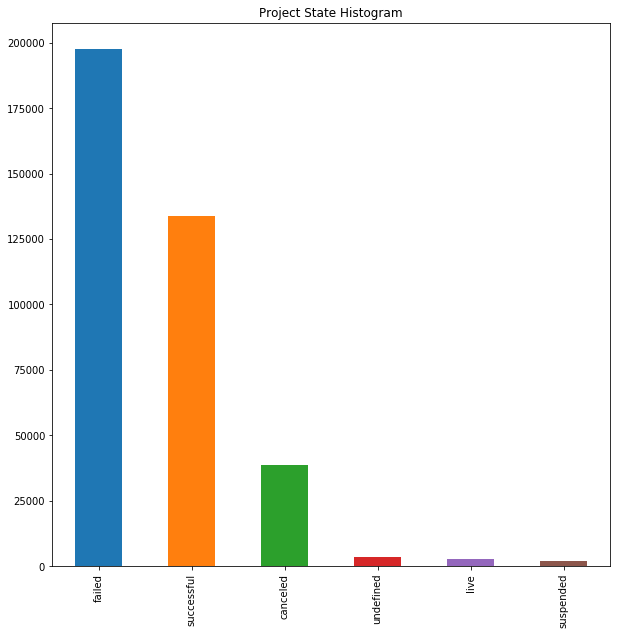

In [14]:
#Plot histogram
kickproj_org['state'].value_counts()

#df.groupby('a').count()
kickproj_org['state'].value_counts().plot(kind='bar', title='Project State Histogram')
#Save image
#pylab.savefig('ProjectStateHistogram.jpg', bbox_inches='tight')

### Drop projects when the state is equal to "undefined":

372300

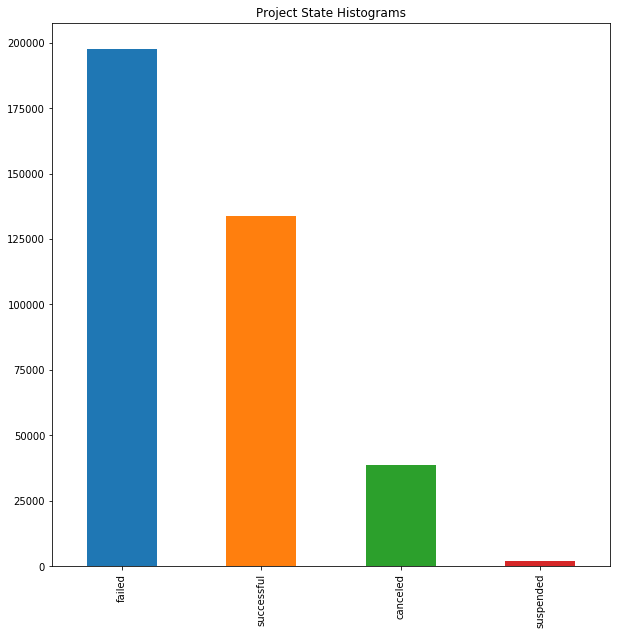

In [8]:
# Remove state = 'undefined'
kickproj = kickproj_org[(kickproj_org['state'] != 'undefined') & (kickproj_org['state'] != 'live')]
len(kickproj)
kickproj['state'].value_counts().plot(kind='bar', title='Project State Histograms')

In [17]:
kickproj.head(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### Since we have the goal and pledge amounts converted to US dollars (usd), we will drop the original goal and pledged columns:

In [18]:
#kickproj = kickproj[kickproj.columns.difference(['goal','pledged','usd pledged'])]
kickproj = kickproj.drop(['goal','pledged','usd pledged'], axis=1)
len(kickproj)
kickproj.head(5)

375099

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled,14,US,1283.0,19500.00


## Check the X data:

In [19]:
kickproj.describe()

,ID,backers,usd_pledged_real,usd_goal_real
count,3.750990e+05,375099.000000,3.750990e+05,3.750990e+05
mean,1.074632e+09,106.620436,9.123935e+03,4.584708e+04
std,6.191294e+08,911.423593,9.140142e+04,1.158404e+06
min,5.971000e+03,0.000000,0.000000e+00,1.000000e-02
25%,5.380782e+08,2.000000,3.100000e+01,2.000000e+03
50%,1.075217e+09,12.000000,6.250000e+02,5.500000e+03
75%,1.610128e+09,57.000000,4.050180e+03,1.600000e+04
max,2.147476e+09,219382.000000,2.033899e+07,1.663614e+08


,ID,backers,usd_pledged_real,usd_goal_real
ID,1.000000,0.000676,-0.000016,0.001868
backers,0.000676,1.000000,0.752528,0.004478
usd_pledged_real,-0.000016,0.752528,1.000000,0.005571
usd_goal_real,0.001868,0.004478,0.005571,1.000000


Heat Map of Correlation Coefficients:


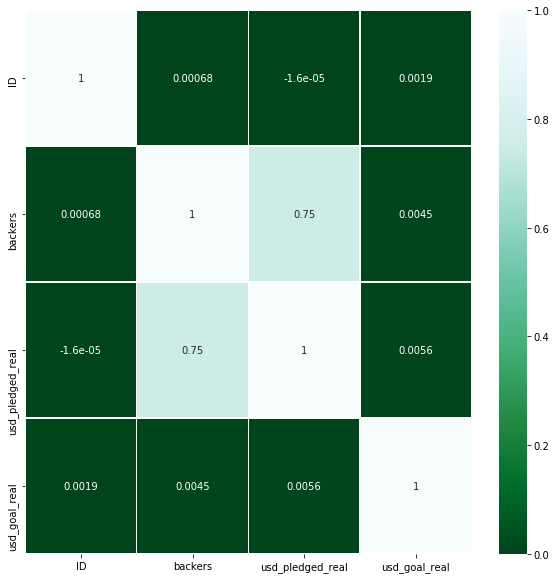

In [30]:
vals = ['ID','backers','usd_pledged_real','usd_goal_real']
kickproj[vals].corr()

#print('Heat Map of Correlation Coefficients:')
#sns.heatmap(kickproj.corr(), cmap="BuGn_r", linewidths=0.5, annot=True)

In [ ]:
categoryDF = kickproj.groupby(['category']).size().reset_index(name='counts')
len(categoryDF)
categoryDF.sort(['counts']).head(5)

,main_category,counts
0,Art,28153
1,Comics,10819
2,Crafts,8809
3,Dance,3767
4,Design,30068
5,Fashion,22813
6,Film & Video,62731
7,Food,24602
8,Games,35230
9,Journalism,4755


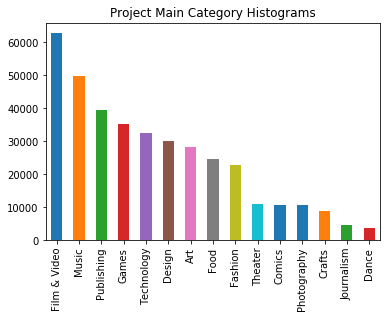

In [58]:
kickproj.groupby(['main_category']).size().reset_index(name='counts')
kickproj['main_category'].value_counts().plot(kind='bar', title='Project Main Category Histograms')

In [59]:
cateDF = kickproj.groupby(['main_category', 'category']).size().reset_index(name='counts')
len(cateDF)
cateDF.head(40)

170

,main_category,category,counts
0,Art,Art,8253
1,Art,Ceramics,305
2,Art,Conceptual Art,1030
3,Art,Digital Art,1346
4,Art,Illustration,3175
5,Art,Installations,482
6,Art,Mixed Media,2757
7,Art,Painting,3294
8,Art,Performance Art,2154
9,Art,Public Art,3077


,country,counts
0,AT,597
1,AU,7839
2,BE,617
3,CA,14756
4,CH,761
5,DE,4171
6,DK,1113
7,ES,2276
8,FR,2939
9,GB,33672


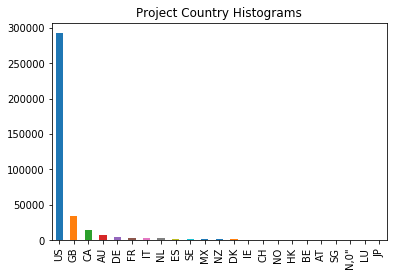

In [60]:
kickproj.groupby(['country']).size().reset_index(name='counts')
kickproj['country'].value_counts().plot(kind='bar', title='Project Country Histograms')

### Remove country with invalid value, N,0"

,country,counts
0,AT,597
1,AU,7839
2,BE,617
3,CA,14756
4,CH,761
5,DE,4171
6,DK,1113
7,ES,2276
8,FR,2939
9,GB,33672


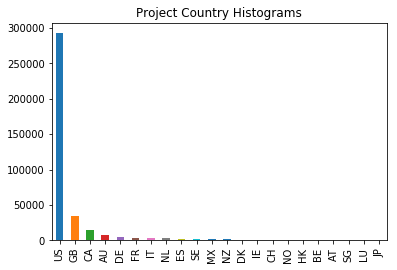

In [61]:
kickproj = kickproj[kickproj['country'] != 'N,0"']
kickproj.groupby(['country']).size().reset_index(name='counts')
kickproj['country'].value_counts().plot(kind='bar', title='Project Country Histograms')

### Check null value 

In [62]:
null_columns=kickproj.columns[kickproj.isnull().any()]
null_columns
kickproj[null_columns].isnull().sum()
kickproj[kickproj["name"].isnull()][null_columns] 

Index([u'name'], dtype='object')

name    4
dtype: int64

,name
166851,NaN
307234,NaN
309991,NaN
338931,NaN


### Replace nan with Unknown for name

In [63]:
kickproj["name"].fillna('Unknown', inplace=True)
null_columns=kickproj.columns[kickproj.isnull().any()]
null_columns

Index([], dtype='object')

### Apply correct data types to DataFrame:

In [21]:
print 'Data types do not align with the data types defined in the data dictionary:\n\n', kickproj.dtypes

Data types do not align with the data types defined in the data dictionary:

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
launched             object
state                object
backers               int64
country              object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object


In [24]:
# Columns that are of date data type:
datecols = ['deadline','launched']
# Columns that are of int data type:
intcols = ['usd_pledged_real','usd_goal_real']

# Convert date columns to date data type:
for col in datecols:
    kickproj[col] = pd.to_datetime(kickproj[col]).dt.date
    kickproj[col] = pd.to_datetime(kickproj[col])

# Convert int columns to int data type:
kickproj[intcols] = kickproj[intcols].fillna(0).astype(np.int64)

In [25]:
print 'Review converted data types:\n\n', kickproj.dtypes

Review converted data types:

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
launched            datetime64[ns]
state                       object
backers                      int64
country                     object
usd_pledged_real             int64
usd_goal_real                int64
dtype: object


In [26]:
kickproj.head()

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11,failed,0,GB,0,1533
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02,failed,15,US,2421,30000
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12,failed,3,US,220,45000
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17,failed,1,US,1,5000
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,2015-07-04,canceled,14,US,1283,19500


### Model Classification Using All Features (Start)

In [27]:
#Encode non-numeric variables - needed to run most of the models, understand anything feature importance:
le = preprocessing.LabelEncoder
d = defaultdict(le)
le_df = kickproj.apply(lambda x: d[x.name].fit_transform(x))

#Split data into two subsets - features and target - looking to predict state of the project:
features = le_df[le_df.columns.drop('state')]
target = le_df['state']

#### Feature Selection Method One: Recursive Feature Elimination

In [69]:
#We'll look at recursive feature elimination (RFE) with logistic regression and select three features:
LogReg_RFE = RFE(LogisticRegression(), 3).fit(features, target)

In [71]:
print('The three most important features according to Logistic Regression:\n'),(np.array(features.columns)[LogReg_RFE.support_])

The three most important features according to Logistic Regression:
['main_category' 'deadline' 'country']


In [72]:
#We'll look at recursive feature elimination (RFE) with linear regression and select three features:
LinReg_RFE = RFE(LinearRegression(), 3).fit(features, target)

In [73]:
print('The three most important features according to Linear Regression:\n'),(np.array(features.columns)[LinReg_RFE.support_])

The three most important features according to Linear Regression:
['currency' 'deadline' 'country']


In [74]:
#We'll use extra trees classifier to calculate feature importance:
ETC = ExtraTreesClassifier().fit(features, target)

In [75]:
feat_imp_df = pd.DataFrame({'Columns':pd.Series(features.columns)})
feat_imp_df['Feature Importance'] = pd.Series(ETC.feature_importances_)
feat_imp_df.set_index(['Columns'],inplace=True)

#### Feature Selection Method Two: Feature Importance

In [76]:
print('Column Names and Associated Feature Importance:')
feat_imp_df

Column Names and Associated Feature Importance:


,Feature Importance
Columns,
ID,0.047990
name,0.048111
category,0.037382
main_category,0.032330
currency,0.006265
deadline,0.058128
launched,0.056302
backers,0.115249
country,0.007574


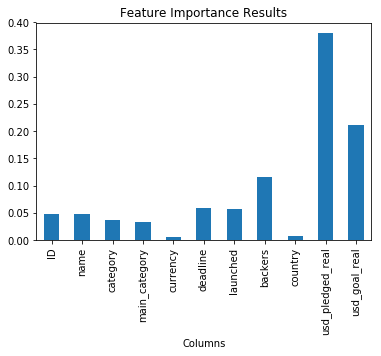

In [77]:
feat_imp_df.plot(kind="bar", title="Feature Importance Results", legend = False)

Observation: according to the extra trees classifier, the most important features are:<br>usd_pledged_real, usd_goal_real, backers<br><br>Let's split the data into test and train and compare approaches.

### Model Execution

In [34]:
#split the dataset in two parts [:n] for training and [n:] for testing (n = 50%)
le_len = int(math.floor(len(le_df)/2))
le_train, le_test = le_df.iloc[:le_len], le_df.iloc[le_len:]

In [35]:
#Create x and y train and test data sets, where x contains features and y contains target
x_train, y_train = le_train[le_train.columns.drop('state')], le_train['state']
x_test, y_test = le_test[le_test.columns.drop('state')],le_test['state']

#### Run battery of algorithms: KNN, Logistic Regression, SVM

In [90]:
#Initialize le_result_Dic:
le_result_Dic = {}

In [91]:
#Algorithm 1: KNN
le_result_Dic = runKNN(x_train, y_train.values.ravel(), x_test, y_test.values.ravel(), 18, trainSetName = 'LE KNN', dic_result_knn = le_result_Dic)

/Users/sidneyfox/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
#Algorithm 2: Logistic Regression
le_result_Dic = runLogistic(x_train, y_train.values.ravel(), x_test, y_test.values.ravel(), trainSetName = 'LE LR', dic_result_log = le_result_Dic)

In [36]:
most_important_cols = ['backers','usd_pledged_real','usd_goal_real']
svm_x_train, svm_y_train = le_train[most_important_cols], le_train['state']
svm_x_test, svm_y_test = le_test[most_important_cols], le_test['state']

In [ ]:
#Algorithm 3: SVM
#le_result_Dic = runSVM(x_train, y_train.values.ravel(), x_test, y_test.values.ravel(), trainSetName = 'LE SVM', dic_result_log = le_result_Dic)

svm.SVC(kernel='linear', C=1.0, decision_function_shape='ovr').fit(svm_x_train, svm_y_train)

In [93]:
le_result_Dic

{'CWeight = None - LE LR': array([ 0.01,  0.89,  0.  ,  0.96,  0.  ,  0.86]),
 'CWeight = balanced - LE LR': array([ 0.04,  0.82,  0.08,  0.92,  0.01,  0.76]),
 'N=11-LE KNN': array([ 0.02,  0.77,  0.  ,  0.7 ,  0.  ,  0.7 ]),
 'N=13-LE KNN': array([ 0.01,  0.77,  0.  ,  0.69,  0.  ,  0.7 ]),
 'N=15-LE KNN': array([ 0.01,  0.77,  0.  ,  0.69,  0.  ,  0.7 ]),
 'N=17-LE KNN': array([ 0.  ,  0.77,  0.  ,  0.69,  0.  ,  0.7 ]),
 'N=3-LE KNN': array([ 0.1 ,  0.75,  0.  ,  0.73,  0.  ,  0.68]),
 'N=5-LE KNN': array([ 0.06,  0.76,  0.  ,  0.73,  0.  ,  0.7 ]),
 'N=7-LE KNN': array([ 0.04,  0.77,  0.  ,  0.72,  0.  ,  0.71]),
 'N=9-LE KNN': array([ 0.03,  0.77,  0.  ,  0.71,  0.  ,  0.71])}

### Model Classification Using All Features (End)

### Find out correlation among variables

In [29]:
kickproj.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
ID,1.000000,0.991679,-0.001201,0.003264,-0.000385,0.010488,0.010688,-0.002991,0.025643,-0.000765,0.122603,0.100961
name,0.991679,1.000000,-0.001672,0.004811,-0.000059,0.010610,0.010534,-0.002681,0.026743,-0.000443,0.123621,0.100064
category,-0.001201,-0.001672,1.000000,0.241871,0.038197,-0.055080,-0.051762,-0.019788,-0.057290,0.038330,-0.067989,0.031169
main_category,0.003264,0.004811,0.241871,1.000000,0.075304,-0.038902,-0.047544,-0.023371,0.027028,0.076911,0.010795,0.071723
currency,-0.000385,-0.000059,0.038197,0.075304,1.000000,-0.018479,-0.021705,-0.033297,-0.011419,0.944815,-0.003260,0.350583
deadline,0.010488,0.010610,-0.055080,-0.038902,-0.018479,1.000000,0.304481,0.046086,-0.006135,-0.019514,0.000498,-0.033184
launched,0.010688,0.010534,-0.051762,-0.047544,-0.021705,0.304481,1.000000,0.038582,-0.019554,-0.022924,-0.012453,-0.033836
state,-0.002991,-0.002681,-0.019788,-0.023371,-0.033297,0.046086,0.038582,1.000000,0.316839,-0.029949,0.431061,-0.065191
backers,0.025643,0.026743,-0.057290,0.027028,-0.011419,-0.006135,-0.019554,0.316839,1.000000,-0.010413,0.568050,0.009392
country,-0.000765,-0.000443,0.038330,0.076911,0.944815,-0.019514,-0.022924,-0.029949,-0.010413,1.000000,0.000752,0.347599


Heat Map of Correlation Coefficients:


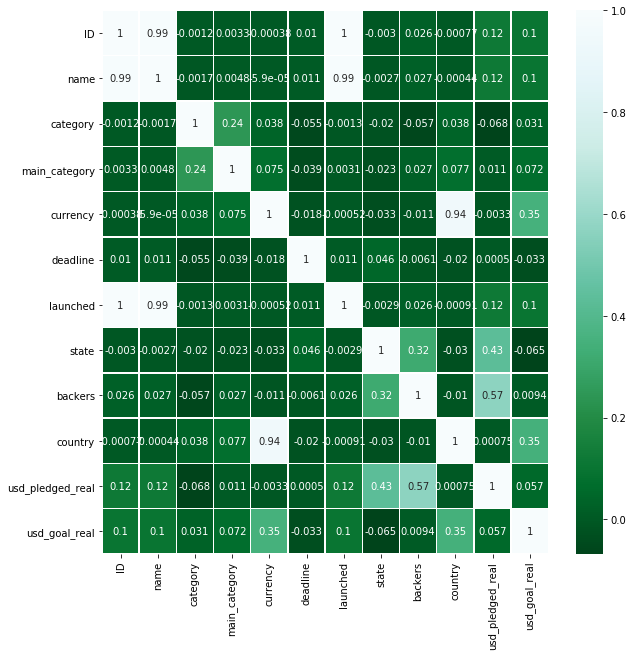

In [132]:
print('Heat Map of Correlation Coefficients:')
sns.heatmap(kickproj.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1), cmap="BuGn_r", linewidths=0.5, annot=True)

In [30]:
def roundup(x, y):
    #return int(math.ceil(x / float(y))) * y
    return int(math.ceil(float(x) / float(y)) * y)
binrange = range(1, roundup(max(kickproj['usd_pledged_real']),100000), 5000000)
binrange

[1, 5000001, 10000001, 15000001, 20000001]

In [31]:
min(kickproj['usd_goal_real'])
max(kickproj['usd_goal_real'])

0

166361390

In [32]:
# All successful records have usd_pledged_real > 0
min(kickproj['usd_pledged_real'])
max(kickproj['usd_pledged_real'])

kickproj[(kickproj['usd_pledged_real']==0) & (kickproj['state']=='successful')]

0

20338986

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real
232312,250850561,What Toodoo based on current weather conditions,Technology,Technology,CAD,735685,735625,successful,1,CA,0,0


#### Create Projects Summary DataFrame:

In [33]:
kickproj_summary = kickproj.groupby(['main_category','state'], as_index=False) \
[['usd_goal_real','usd_pledged_real','backers']].agg({
    'usd_goal_real':[np.sum, np.mean, np.std],
    'usd_pledged_real':[np.sum, np.mean, np.std],
    'backers':[np.sum, np.mean, np.std,'count']
})

#"Flatten" summary results:
kickproj_summary.columns = list(map('_'.join, kickproj_summary.columns.values))

#Rename a few columns:
kickproj_summary.columns.values[-1] = 'project_count'
kickproj_summary.columns.values[0] = 'main_category'
kickproj_summary.columns.values[1] = 'state'

kickproj_summary.head()

,main_category,state,usd_goal_real_sum,usd_goal_real_mean,usd_goal_real_std,usd_pledged_real_sum,usd_pledged_real_mean,usd_pledged_real_std,backers_sum,backers_mean,backers_std,project_count
0,Art,canceled,88606593,39876.954545,4.895348e+05,1082902,487.354635,1913.420167,16127,7.257876,24.230278,2222
1,Art,failed,960317816,67958.234803,1.840814e+06,8831025,624.939849,2890.981476,124655,8.821386,28.250023,14131
2,Art,live,2989653,15410.582474,8.691543e+04,463699,2390.201031,13561.788361,6271,32.324742,155.476279,194
3,Art,successful,50759075,4409.997828,1.027395e+04,80244909,6971.755778,33621.781341,1040022,90.358123,325.885620,11510
4,Art,suspended,881418,9181.437500,3.284727e+04,54835,571.197917,2335.840102,1125,11.718750,53.503311,96


In [48]:
shffled_kickproj = kickproj.sample(frac=1)

In [49]:
#df['c'] = df.apply(lambda row: row.a + row.b, axis=1)
shffled_kickproj['state_cd'] = shffled_kickproj['state'].apply(lambda a: True if a == 'successful' else False)
shffled_kickproj.head(5)

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_cd
170593,1867847796,Ceramic Pie Studios,Ceramics,Art,USD,2017-03-11,2017-01-10 18:50:54,failed,6,US,190.00,325000.00,False
65598,1333617365,The CockBlock Paperweight ™ aka Roostercube,Design,Design,USD,2011-04-21,2011-03-11 06:51:52,failed,14,US,565.00,1200.00,False
88858,1451669319,"""The Fat Bastard Diet Book"" by Dr Dieter Bloat...",Fiction,Publishing,GBP,2015-04-12,2015-03-13 20:21:23,failed,3,GB,82.62,1068.03,False
228235,2304437,See Sense : The intelligent bike light with ro...,Product Design,Design,GBP,2013-11-08,2013-10-09 10:29:03,successful,504,GB,54393.87,19296.33,True
265780,422055986,"""Afterwords"" - Kiss It Goodbye",Music,Music,GBP,2014-10-05,2014-09-10 21:08:10,successful,14,GB,949.22,633.35,True


In [50]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(shffled_kickproj['country'])
shffled_kickproj['country_cd'] = le.transform(shffled_kickproj['country'])
shffled_kickproj.head(5)

LabelEncoder()

,ID,name,category,main_category,currency,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,state_cd,country_cd
170593,1867847796,Ceramic Pie Studios,Ceramics,Art,USD,2017-03-11,2017-01-10 18:50:54,failed,6,US,190.00,325000.00,False,21
65598,1333617365,The CockBlock Paperweight ™ aka Roostercube,Design,Design,USD,2011-04-21,2011-03-11 06:51:52,failed,14,US,565.00,1200.00,False,21
88858,1451669319,"""The Fat Bastard Diet Book"" by Dr Dieter Bloat...",Fiction,Publishing,GBP,2015-04-12,2015-03-13 20:21:23,failed,3,GB,82.62,1068.03,False,9
228235,2304437,See Sense : The intelligent bike light with ro...,Product Design,Design,GBP,2013-11-08,2013-10-09 10:29:03,successful,504,GB,54393.87,19296.33,True,9
265780,422055986,"""Afterwords"" - Kiss It Goodbye",Music,Music,GBP,2014-10-05,2014-09-10 21:08:10,successful,14,GB,949.22,633.35,True,9


In [51]:
num = shffled_kickproj.shape[0]/2

train_x, train_y = shffled_kickproj.iloc[0:num, [5,6,8,9,10,11,13]], shffled_kickproj.iloc[0:num, 12]
test_x, test_y = shffled_kickproj.iloc[num:, [5,6,8,9,10,11,13]], shffled_kickproj.iloc[num:, 12]
train_x.head(2)
train_x.shape
train_y.head(2)
train_y.shape
test_x.head(2)
test_x.shape
test_y.head(2)
test_y.shape

,deadline,launched,backers,country,usd_pledged_real,usd_goal_real,country_cd
170593,2017-03-11,2017-01-10 18:50:54,6,US,190.0,325000.0,21
65598,2011-04-21,2011-03-11 06:51:52,14,US,565.0,1200.0,21


(187432, 7)

170593    False
65598     False
Name: state_cd, dtype: bool

(187432,)

,deadline,launched,backers,country,usd_pledged_real,usd_goal_real,country_cd
24242,2013-07-03,2013-06-03 18:56:36,4,US,41.0,1170.0,21
333658,2015-03-31,2015-03-01 05:59:54,0,US,0.0,40000.0,21


(187432, 7)

24242     False
333658    False
Name: state_cd, dtype: bool

(187432,)

### Train training set

In [52]:
temp_features_train = train_x['country_cd'].reshape(-1, 1) # Needs to be the correct shape
temp_features_test = test_x['country_cd'].reshape(-1, 1) # Needs to be the correct shape

/Users/sidneyfox/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/sidneyfox/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [53]:
ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
#fit on training set only
ohe.fit(temp_features_train)
countryDF_train = DataFrame(ohe.transform(temp_features_train), columns = ohe.active_features_, index = train_x.index)
countryDF_test = DataFrame(ohe.transform(temp_features_test), columns = ohe.active_features_, index = test_x.index)
countryDF_train.head(10)
countryDF_test.head(10)

OneHotEncoder(categorical_features='all', dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
170593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
88858,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
372431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
112941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
24242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
333658,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
343717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
126072,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
170577,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
188075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
307901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
334714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
train_x.shape
countryDF_train.shape
test_x.shape
countryDF_test.shape

(187432, 7)

(187432, 22)

(187432, 7)

(187432, 22)

In [55]:
train_X1 = pd.merge(train_x.drop(['country','country_cd'], axis=1), countryDF_train, left_index=True, right_index=True)
train_X1.head(10)
train_X1.shape

test_X1 = pd.merge(test_x.drop(['country','country_cd'], axis=1), countryDF_test, left_index=True, right_index=True)
test_X1.head(10)
test_X1.shape

,deadline,launched,backers,usd_pledged_real,usd_goal_real,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,21
170593,2017-03-11,2017-01-10 18:50:54,6,190.00,325000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
65598,2011-04-21,2011-03-11 06:51:52,14,565.00,1200.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
88858,2015-04-12,2015-03-13 20:21:23,3,82.62,1068.03,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228235,2013-11-08,2013-10-09 10:29:03,504,54393.87,19296.33,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
265780,2014-10-05,2014-09-10 21:08:10,14,949.22,633.35,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31131,2014-10-15,2014-08-16 00:15:14,2,14.11,769.38,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
372431,2018-01-12,2017-11-13 19:47:06,29,1254.96,3641.09,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375064,2015-01-20,2014-12-21 09:18:47,0,0.00,50000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
112941,2011-03-19,2011-02-17 23:55:12,0,0.00,15000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
48828,2013-02-03,2013-01-04 15:02:30,1,25.00,800.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


(187432, 27)

,deadline,launched,backers,usd_pledged_real,usd_goal_real,0,1,2,3,4,...,12,13,14,15,16,17,18,19,20,21
24242,2013-07-03,2013-06-03 18:56:36,4,41.00,1170.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
333658,2015-03-31,2015-03-01 05:59:54,0,0.00,40000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223644,2014-03-21,2014-02-19 08:35:24,12,116.00,1000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
343717,2015-12-23,2015-11-19 19:23:40,124,9463.00,20000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
126072,2012-07-06,2012-06-21 02:34:54,1,30.00,2000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
170577,2015-03-01,2015-01-30 16:55:47,326,18526.22,16702.60,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66960,2015-11-22,2015-11-02 01:43:53,322,50842.00,47970.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
188075,2012-10-03,2012-09-17 20:51:51,40,2596.00,2400.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
307901,2016-05-14,2016-04-14 05:30:29,9,303.00,3000.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
334714,2015-05-20,2015-04-20 00:46:41,0,0.00,11730.11,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(187432, 27)

In [56]:
result_Dic = {}
#Call function to run KNeighborsClassifier with different n_neighbors settings (up to 20) and store the f1 score results
result_Dic = runKNN(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), 18, trainSetName = 'Basic&Country', dic_result_knn = result_Dic)

ValueError: invalid literal for float(): 2013-09-04 14:15:50

In [57]:
#Call function to run LogisticRegression with different class_weight settings (None or Balance)  and store the f1 score results
result_Dic = runLogistic(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), trainSetName = 'Basic&Country', dic_result_log = result_Dic)

ValueError: invalid literal for float(): 2013-09-04 14:15:50

In [45]:
# Call function to run LogisticSVM with different kernel settings (linear, rbf or poly)  and store the f1 score results
# result_Dic = runSVM(train_X1, train_y.values.ravel(), test_X1, test_y.values.ravel(), trainSetName = 'Basic&Country', dic_result_log = result_Dic)

In [46]:
#Store number of classes
n_classes = np.unique(shffled_kickproj['state_cd'])
n_classes
resultDF = formatResult(result_Dic, np.append(n_classes, 'micro'))
resultDF.head(10)

array([False,  True], dtype=bool)

,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.00,0.99,0.99,2.98
N=15-Basic&Country,0.99,0.99,0.99,2.97
N=11-Basic&Country,0.99,0.99,0.99,2.97
N=13-Basic&Country,0.99,0.99,0.99,2.97
N=3-Basic&Country,1.00,0.99,0.99,2.98
N=17-Basic&Country,0.99,0.99,0.99,2.97
CWeight = None - Basic&Country,0.98,0.97,0.98,2.93
N=7-Basic&Country,1.00,0.99,0.99,2.98
CWeight = balanced - Basic&Country,0.97,0.94,0.96,2.87
N=9-Basic&Country,0.99,0.99,0.99,2.97


In [47]:
# Print out the top 10 Micro (overall) F1 score from all settings
resultDF.drop('sum').nlargest(5, 'micro')
resultDF.drop('sum').nlargest(5, 'Sum of Class F1')

,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.00,0.99,0.99,2.98
N=15-Basic&Country,0.99,0.99,0.99,2.97
N=11-Basic&Country,0.99,0.99,0.99,2.97
N=13-Basic&Country,0.99,0.99,0.99,2.97
N=3-Basic&Country,1.00,0.99,0.99,2.98


,False,True,micro,Sum of Class F1
N=5-Basic&Country,1.00,0.99,0.99,2.98
N=3-Basic&Country,1.00,0.99,0.99,2.98
N=7-Basic&Country,1.00,0.99,0.99,2.98
N=15-Basic&Country,0.99,0.99,0.99,2.97
N=11-Basic&Country,0.99,0.99,0.99,2.97


In [58]:
knnClr = KNeighborsClassifier(n_neighbors=5)
knnClr.fit(train_X1, train_y.values.ravel())
final_y_pred = knnClr.predict(test_X1)

ValueError: invalid literal for float(): 2013-09-04 14:15:50

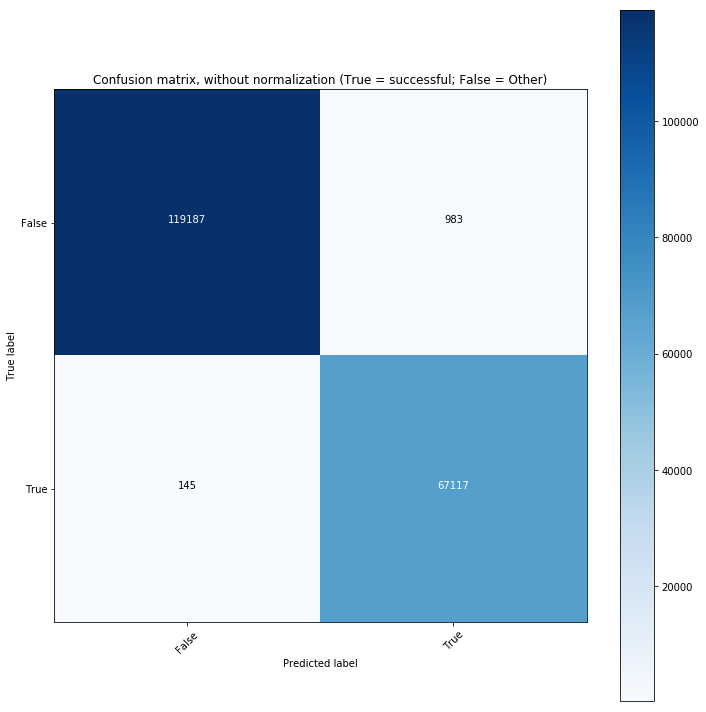

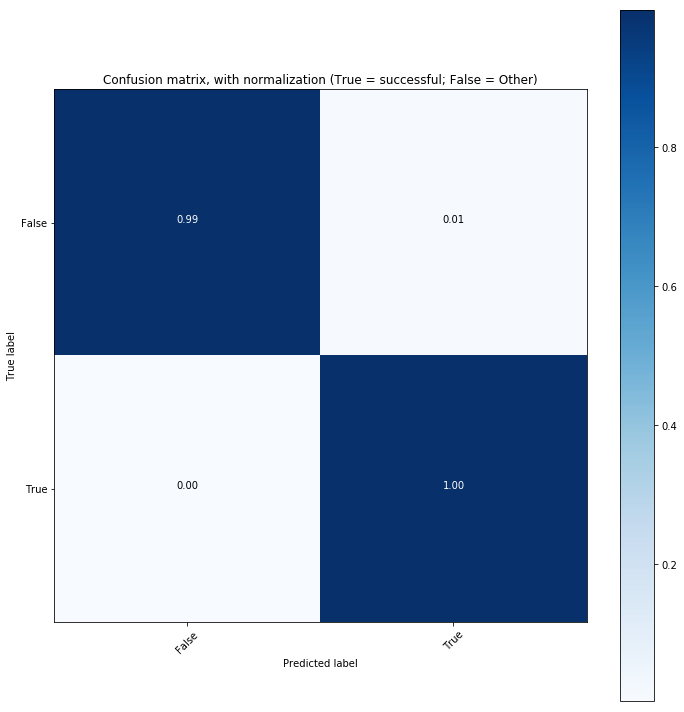

In [49]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y, final_y_pred)
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[False,True],
                      normalize=False,
                      title='Confusion matrix, without normalization (True = successful; False = Other)')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[False,True],
                      normalize=True,
                      title='Confusion matrix, with normalization (True = successful; False = Other)')

In [50]:
stats = show_statistics(test_y, final_y_pred, cnf_matrix)
strName = map((lambda a: 'successful' if a == True else 'Failed/Cancelled/Live/Suspended'),  [False, True])
print "Classificaiton Report:"
print classification_report(test_y, final_y_pred, target_names=strName, digits=2)

Classificaiton Reprt:
                                 precision    recall  f1-score   support

Failed/Cancelled/Live/Suspended       1.00      0.99      1.00    120170
                     successful       0.99      1.00      0.99     67262

                    avg / total       0.99      0.99      0.99    187432

